# Домашнее задание 2 (Линейная регрессия и KNN)

В каждом пункте от вас потребуется дописать код, необходимый для реализации задания, а так же ответить на ряд вопросов, проанализировав полученные результаты. Просьба отвечать на вопросы развёрнуто, аппелируя к полученным значениям или графикам, ответы вписывать в отдельную ячейку, выбрав для неё тип "Markdown". От полноты и качества ответов будет во многом зависеть ваша итоговая оценка.

Задание выполняется самостоятельно, плагиат будет стандартно наказываться лишением всех баллов за задание.

- Максимальная оценка за задание: 10 баллов.
- Дата выдачи: 28.2.2018
- Срок сдачи: 23:59 13.3.2018

In [19]:
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
%matplotlib inline

## Часть 1. Работа с модельными данными

В данном пункте требуется разобраться с базовыми техниками регрессионного анализа и сравнить их между собой на данных, чьи характеристики вы уже знаете (т.е., вам их придётся сгенерировать). Тем самым вы сами выявите все преимущества и недостатки используемых методов перед тем, как применять их на реальных данных, где полученные результаты, вообще говоря, без предварительных знаний могут плохо поддаваться объяснению.

Как вам уже известно из семинаров и лекций, существуют разные типы регрессии, которые определяют форму и свойства регрессионных кривых. Вы разберётесь с двумя основными способами их задания: трансформацией исходных данных $X$, а так же изменением оптимизируемого функционала $Q(w, b, \theta)$, где $w, b$ -- настраиваемые параметры линейной регрессии, $\theta$ -- т.н. гиперпараметры алгоритма построения регрессии, которые не настраиваются по обучающей выборке напрямую, поэтому всегда выделяются отдельно.

### 1.1. Генерация данных

От вас потребуется использовать уже знакомый по заданию 1 метод генерации данных для регрессии функций с линейным шумом:

In [1050]:
def get_grid(n, D, x_min, x_max):
    """Генерирует сетку размера n^D x D"""
    xn = np.linspace(x_min, x_max, n)
    xn = np.meshgrid(*([xn]*D))
    return np.concatenate([xi.reshape((n**D, 1)) for xi in xn], axis=1)

def gen_data(n, D, x_min, x_max, f_target, f_noise):
    """Возвращает аргументы и зашумлённые значения для заданной функции
    
    Данная функция принимает на вход параметры выборки, которую требуется
    сгенерировать, а так же ссылки на функции, которые должны
    использоваться при генерации.
    
    n        -- размер одномерной выборки (совпадает с N при D=1)
    D        -- размерность выборки
    f_target -- целевая функция, которую будет аппроксимировать регрессия
    f_noise  -- функция, которая генерирует шум
    
    Возвращает сгенерированные данные и ответы на этих данных, а так же
    истинные значения функции
    
    X    -- выборка размера NxD, где N=n^D
    y    -- зашумлённые значения целевой функции
    y_gt -- истинные значения целевой функции"""
    X = get_grid(n, D, x_min, x_max)
    N = X.shape[0]
    y_gt = f_target(X)
    y = y_gt + f_noise(N)
    return X, y, y_gt

Пример генерации выборки для одномерной линейной функции с шумом $y = 2x + 3 + \epsilon$, где $x$ -- детерминированная переменная, $\epsilon$ -- шум  из нормального распределения с параметрами $\mu = 2, \sigma^2 = 4$, обозначение: $\epsilon \sim \mathcal{N}(2, 4)$.

In [1051]:
def f_target(X):
    return 2*X + 3

def f_noise(N):
    """Обратите внимание, что функция random.normal принимает на вход
    стандартное отклонение, т.е. корень из диспресии"""
    return np.random.normal(loc=2, scale=2, size=N).reshape((N, 1))

X, y, y_gt = gen_data(10, 1, 0, 10, f_target, f_noise)

### 1.2. Знакомство с библиотеками

Для реализации регрессии вам потребуется пользоваться классами из библиотеки sklearn, в которой собраны практически все основные методы машинного обучения.

Базовым методом построения регрессии является линейная регрессия. Для её обучения предлагается использовать класс LinearRegression из модуля sklearn.linear_model

Оптимизируемый ей функционал записывается в следующем уже знакомом вам виде: $$ Q(w, b) = \sum_{i=1}^\ell (<x_i, w> +~ b - y_i)^2 \longrightarrow \min\limits_{w,b} $$

Описание класса: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

Так же вы познакомитесь с ещё двумя моделями регрессии: Ridge регрессия, которая призвана позволить регрессии работать лучше в случае, когда в признаках присутствовует линейная зависимость, и регрессия Lasso, которая дополнительно осуществляет отбор более информативных с её точки зрения признаков.

Функционал для Ridge регрессии:

$$ Q(w, b, \alpha) = \sum_{i=1}^\ell (<x_i, w> +~ b - y_i)^2 + \frac{1}{\alpha} \sum_{d=1}^D w_d^2  \longrightarrow \min\limits_{w,b} $$

Как видно, выбор оптимальных $w$ и $b$ будет существенно зависеть от выбора $\alpha$, но при этом сам параметр $\alpha$ в задаче оптимизации, решаемой по обучающей выборке, не участвует и участвовать не может, поэтому называется гиперпараметром данной модели.

Это означает, что Ridge регрессия (как и регрессия Lasso) уже не является решением out of the box, у самого алгоритма присутствуют так называемый гиперпараметр, от выбора которого напрямую будет зависеть качество решения вашей задачи. Такая ситуация крайне типична для машинного обучения. Для настройки параметров существует несколько подходов, и вы с ними познакомитесь позже. Пока что вам предлагается пользоваться регрессиями с параметрами по умолчанию.

Функционал для регрессии Lasso:

$$ Q(w, b, \alpha) = \sum_{i=1}^\ell (<x_i, w> +~ b - y_i)^2 + \frac{1}{\alpha} \sum_{d=1}^D |w_d|  \longrightarrow \min\limits_{w,b} $$

Описание класса Ridge: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

Описание класса Lasso: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

Ещё при построении регрессионных кривых сложного вида широко используется механизм трансформации признаков, когда вы некоторым способом делаете преобразование вашей выборки, генерируя по ней новую матрицу признаков размера NxD', где D' > D, и уже на новой выборке обучаете линейную регрессию.

Например, если в исходной матрице у вас всего два признака a и b, то, преобразовав их в [1, a, b, a^2, ab, b^2], вы сможете, применяя линейную регрессию на новых признаках, получать регрессионные кривые второго порядка.

Эти преобразования для любой степени итогового полинома выполняет класс PolynomialFeatures.

Описание класса: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn-preprocessing-polynomialfeatures

### 1.3. Эксперименты

Т.к. эксперименты мы будем проводить на искусственных данных, то для них мы всегда знаем значения незашумлённой функции, поэтому качество работы методов будем оценивать следующим функционалом усреднённой ошибки: $$\text{err}\ (y_{pred}, y_{gt}) = \frac{1}{N} \sum_{n=1}^N (y_{pred} - y_{gt})^2 $$ где $y_{pred}$ -- значения, предсказанные регрессией, $y_{gt}$ -- истинные значения функции (gt здесь сокращение от groundtruth, т.е. истинная незашумлённая функция).

#### Эксперимент 1

Сгенерируйте зашумлённую выборку для функции $y = x + \epsilon$, где $x$ принимает значения из равномерной сетки на [0, 3], а $\epsilon \sim \mathcal{N}(0, 1)$. Постройте график зависимости ошибки вашей линейной регрессии от размера выборки. При каком размере выборки регрессионная прямая перестаёт быть визуально отличимой от истинной? Постройте график с истинной прямой и обученной посредством регрессии.

Пример вызова класса, выполняющего линейную регрессию:

    LR = lm.LinearRegression()
    LR.fit(X_train, y_train)
    y_pred = LR.predict(X_train)

In [1052]:
def f_target(X):
    return X

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

N_grid = list(range(10, 1000, 10)) # список N, для которых требуется провести эксперимент

X, y, y_gt = gen_data(N_grid[-1], 1, 0, 3, f_target, f_noise) # Сгенерированные данные

Для каждого N в цикле добавьте в список err ошибку регрессии, которую вы обучили на случайных N элементах датасета. Ошибку требуется считать как MSE. Так же для каждого N сохраните обученные классы регрессии в список LRs (в примере вызова класс назван LR). predict делайте на всей выборке X.

In [1053]:
from sklearn.metrics import mean_squared_error

In [1054]:
err = []
LRs = []
LRs = lm.LinearRegression()
for N in N_grid:
    X, y, y_gt = gen_data(N, 1, 0, 3, f_target, f_noise)
    LRs.fit(X, y)
    y_pred = LRs.predict(X)
    err.append(mean_squared_error(y_pred, y_gt))

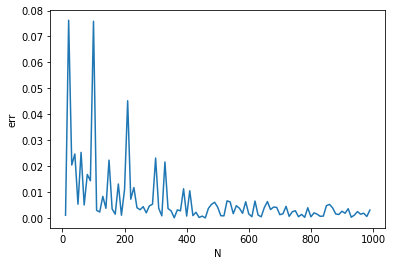

In [1025]:
plt.plot(range(10, 1000, 10), err)
plt.xlabel("N")
plt.ylabel("err")
plt.show()

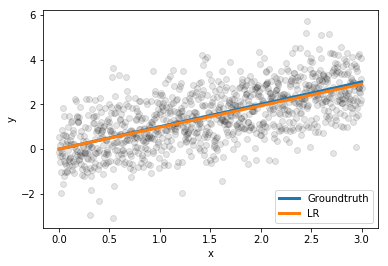

In [1026]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
plt.plot(X, y_pred, linewidth=3)
plt.legend(["Groundtruth", "LR"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Проделайте тоже самое для KNN при n_neighbors=3.

In [1027]:
from sklearn.neighbors import KNeighborsRegressor

In [1028]:
err = []
KNNs = KNeighborsRegressor(n_neighbors=3)
for N in N_grid:
    X, y, y_gt = gen_data(N, 1, 0, 3, f_target, f_noise)
    KNNs.fit(X,y)
    y_pred = KNNs.predict(X)
    err.append(mean_squared_error(y_pred, y_gt))

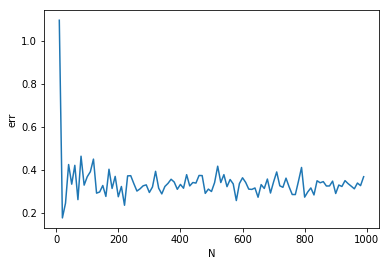

In [1029]:
plt.plot(range(10, 1000, 10), err)
plt.xlabel("N")
plt.ylabel("err")
plt.show()

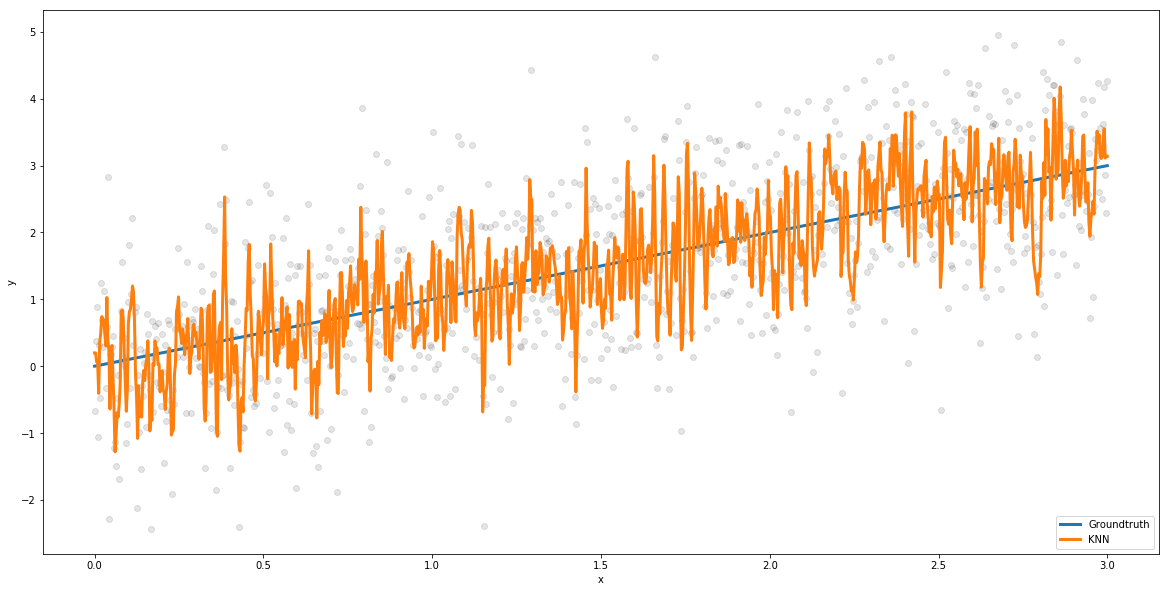

In [1030]:
plt.figure(figsize=(20,10))
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
plt.plot(X, y_pred, linewidth=3)
plt.legend(["Groundtruth", "KNN"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Увеличте число соседей до 10 и проделайте тоже самое.

In [1031]:
err = []
KNNs = KNeighborsRegressor(n_neighbors=10)
for N in N_grid:
    X, y, y_gt = gen_data(N, 1, 0, 3, f_target, f_noise)
    KNNs.fit(X,y)
    y_pred = KNNs.predict(X)
    err.append(mean_squared_error(y_pred, y_gt))

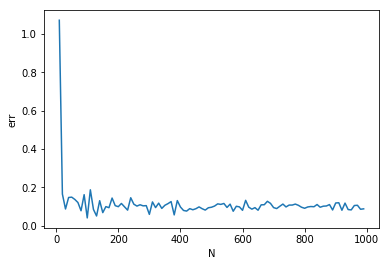

In [1032]:
plt.plot(range(10, 1000, 10), err)
plt.xlabel("N")
plt.ylabel("err")
plt.show()

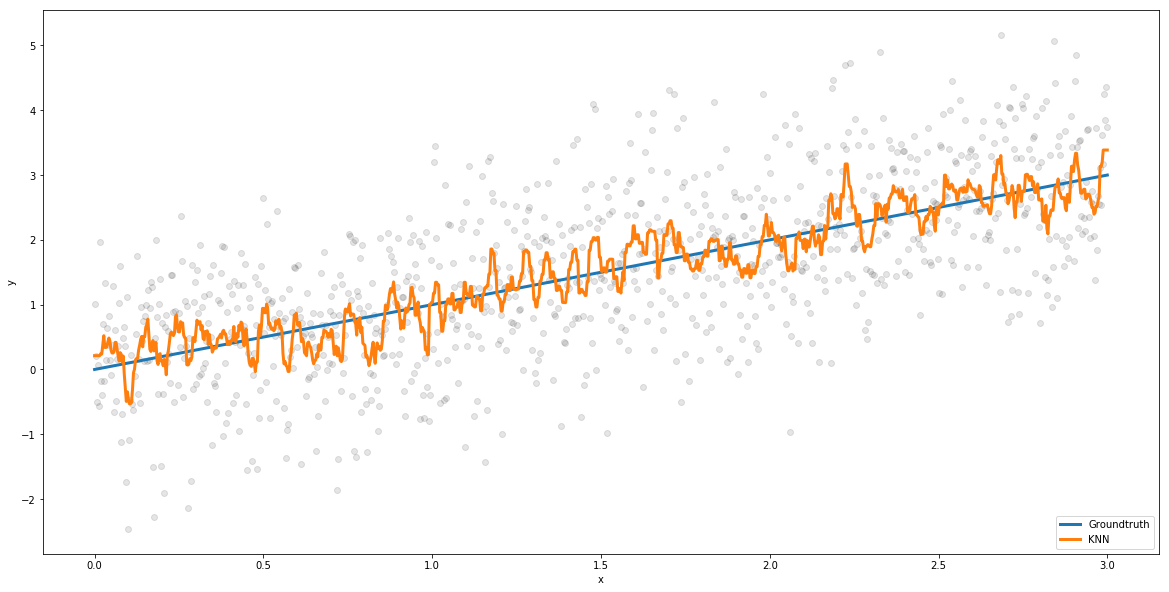

In [1033]:
plt.figure(figsize=(20,10))
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
plt.plot(X, y_pred, linewidth=3)
plt.legend(["Groundtruth", "KNN"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Какие выводы можно сделать?

Анализируя графики, показывающие усреднённую ошибку, можно сказать, что чем больше выборка, тем меньше ошибка. 
При использовании линейной регрессии прямая (LR) почти не отличила от прямой истинных значений функции.  
Можно заметить высокую амплитуда колебаний, особенно при малой выборки. Чем больше количество соседей, тем ближе прямая KNN к прямой истинных значений, то есть алгоритм с большим N_neighbors пок более устойчив к выбросам.


#### Эксперимент 2

Изучим поведение регрессии с полиномиальными признаками. Для этого будем использовать класс PolynomialFeatures. Код вызова выглядит примерно так:

        import sklearn.preprocessing as pp
        pp.PolynomialFeatures(degree=d_new)
        X_new = pp.fit_transform(X)

Сгенерируйте выборку для $y = log \frac{1}{3} x + \epsilon$, где $x$ принимает значения из равномерной сетки на  [1, 10], $\epsilon \sim \mathcal{N}(0, 1)$. Рассмотрите три случая: линейный, полиномиальные признаки степени 2 и 5. Для каждого постройте графики, аналогичные графику из эксперимента 1 и сравните их. Какой эффект вы наблюдаете? По какой причине он возникакет? Постройте график истинной кривой, и наилучших среди полиномиальных, которые вы исследовали. Какая из них лучше всего приближает данные и почему?

In [1034]:
import sklearn.preprocessing as pp

def f_target(X):
    return np.log(0.3*X)

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

N_grid = np.arange(10, 1000, 10)
X, y, y_gt = gen_data(N_grid[-1], 1, 1, 10, f_target, f_noise)

Аналогично предыдущему пункту, обучите в трёх циклах три разные регрессии, сохраняя полученные ошибки и классы в списки err_i и LRs_i. Перед обучением второй и третьих моделей вам требуется преобразовать признаки в полиномиальные, используя указанный в примере класс PolynomialFeatures. Сохраните полученные признаки степени 2 в переменную X_new_2, а признаки степени 5 в переменную X_new_3. Обучение соответственно происходит на выборках (X, y), (X_new_2, y), (X_new_3, y).

In [1035]:
err_1 = []
LRs = lm.LinearRegression()
for N in N_grid:
    X, y, y_gt = gen_data(N, 1, 1, 10, f_target, f_noise)
    LRs.fit(X, y)
    y_pred_1 = LRs.predict(X)
    err_1.append(mean_squared_error(y_pred_1, y_gt))
    
    
err_2 = []
Poly = pp.PolynomialFeatures(degree=2)

for N in N_grid:
    X, y, y_gt = gen_data(N, 1, 1, 10, f_target, f_noise)
    X_new = Poly.fit_transform(X)
    LRs.fit(X_new, y)
    y_pred_2 = LRs.predict(X_new)
    err_2.append(mean_squared_error(y_pred_2, y_gt))
    
    
    
err_3 = []
Poly = pp.PolynomialFeatures(degree=5)
X_new = Poly.fit_transform(X)

for N in N_grid:
    X, y, y_gt = gen_data(N, 1, 1, 10, f_target, f_noise)
    X_new = Poly.fit_transform(X)
    LRs.fit(X_new, y)
    y_pred_3 = LRs.predict(X_new)
    err_3.append(mean_squared_error(y_pred_3, y_gt))

Код для построения всех графиков:

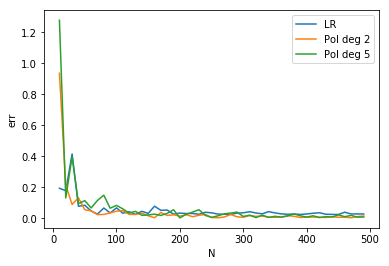

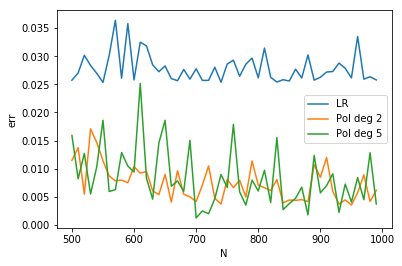

In [1036]:
plt.plot(N_grid[:N_grid.size//2], err_1[:N_grid.size//2])
plt.plot(N_grid[:N_grid.size//2], err_2[:N_grid.size//2])
plt.plot(N_grid[:N_grid.size//2], err_3[:N_grid.size//2])
plt.legend(["LR", "Pol deg 2", "Pol deg 5"])
plt.xlabel("N")
plt.ylabel("err")
plt.show()

plt.plot(N_grid[N_grid.size//2:], err_1[N_grid.size//2:])
plt.plot(N_grid[N_grid.size//2:], err_2[N_grid.size//2:])
plt.plot(N_grid[N_grid.size//2:], err_3[N_grid.size//2:])
plt.legend(["LR", "Pol deg 2", "Pol deg 5"])
plt.xlabel("N")
plt.ylabel("err")
plt.show()

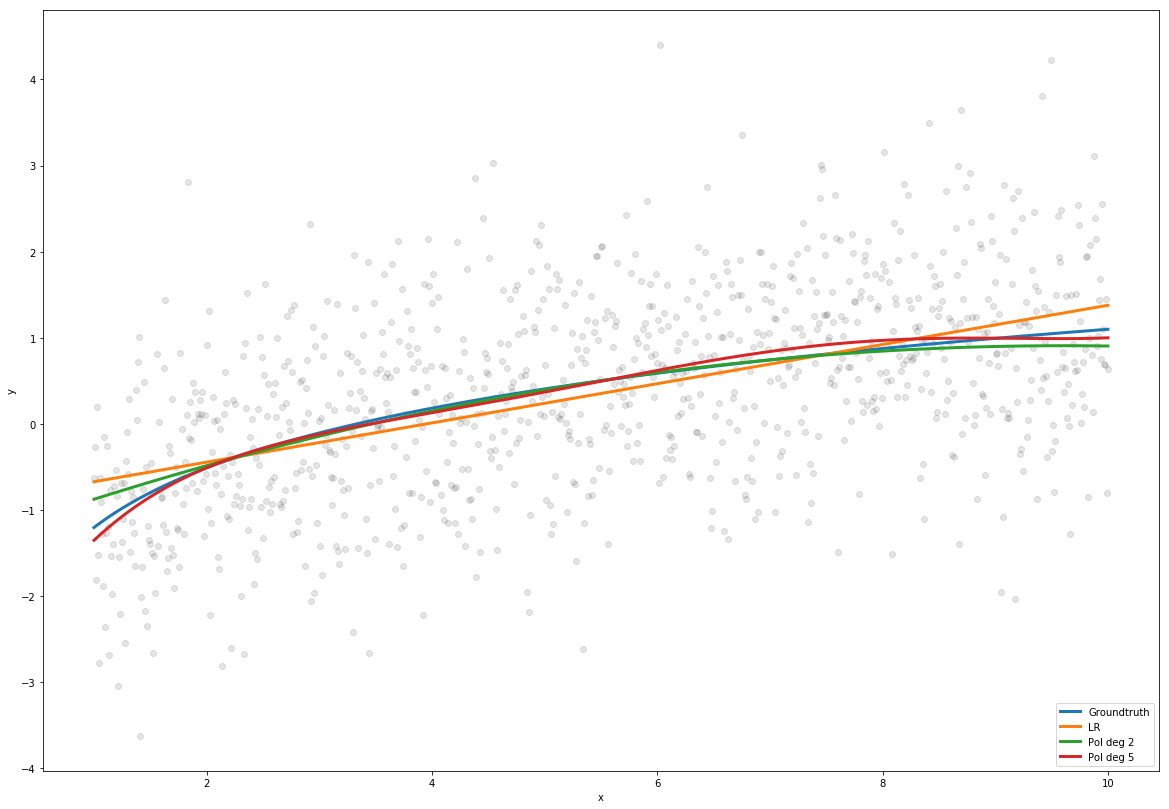

In [1037]:
plt.figure(figsize=(20,14))
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
plt.plot(X, y_pred_1, linewidth=3)
plt.plot(X, y_pred_2, linewidth=3)
plt.plot(X, y_pred_3, linewidth = 3)
plt.legend(["Groundtruth", "LR", "Pol deg 2", "Pol deg 5"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

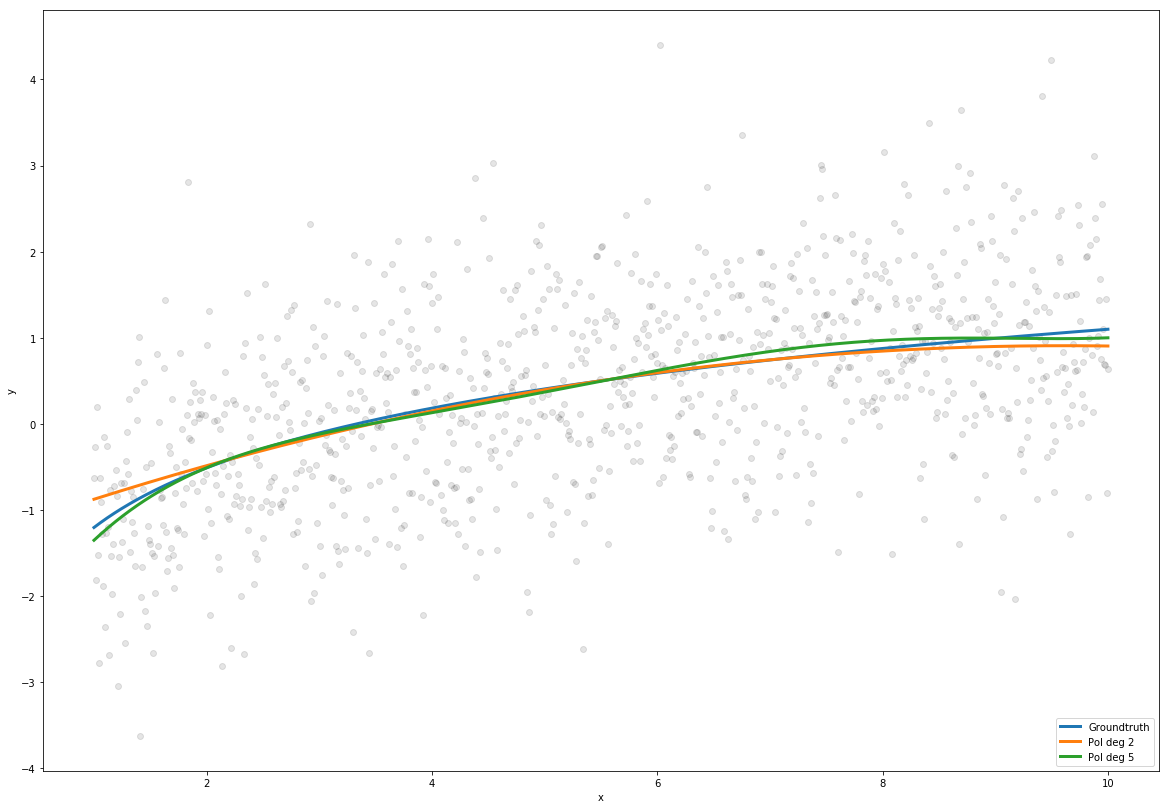

In [1038]:
plt.figure(figsize=(20,14))
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
plt.plot(X, y_pred_2, linewidth=3)
plt.plot(X, y_pred_3, linewidth = 3)
plt.legend(["Groundtruth", "Pol deg 2", "Pol deg 5"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

При использовании полиномальных признаков ошибка меньше, особенно на большой выборке. Также полиномиальная прямая более приближена к истинной прямой. Если между x и y не прямая зависимость, а логорифмическая(как. этом эксперименте), то лучше использовать регрессию с полиномиальными признаками. Разница между использованием полиномиальных признаков различных степеней незначительная, поэтому их трудно сравнить (Можно сказать, что со степенью 2, прямая больше приближена к истинной, так как проходит без колебаний. Со степенью 5 менее устойчива к выбросам, так как величина всех показателей возрастает)

#### Эксперимент 3

Рассмотрим данные с искусственно внесёнными в них линейными зависимостями. Для наглядности рассмотрим регрессию, которая фактически зависит лишь от одной переменной, но в сгенерированный набор данных внесём ещё несколько признаков, которые будут слабо коррелировать с первым.

Сгенерируйте зашумлённую выборку для функции $y = x + \epsilon$, $x$ принимает значения из равномерной сетки на [0, 3], $\epsilon \sim \mathcal{N}(0, 1)$. Добавьте в качестве второго признака $x_2 = 2x + \delta$, где $\delta \sim \mathcal{N}(0, 0.01)$, а в качестве третьего $x_3 = x_1 + x_2 + \nu$, где $\nu \sim \mathcal{N}(0, 0.25)$. Постройте графики истинной функции, линейной регрессии и Ridge регрессии, в зависимости от первого столбца данных (при этом саму регрессию нужно обучать по всем трём признакам). Какой эффект вы наблюдаете? Какая регрессия работает лучше и почему? (Для ответа на этот вопрос можете, например, сравнить веса признаков, полученные в случае обычной и Ridge линейных регрессий, параметр класса: coef_)

Пример вызова класса, выполняющего Ridge регрессию:

    Ridge = lm.Ridge()
    Ridge.fit(X_train, y_train)
    y_pred = LR.predict(X_train)

In [1058]:
def f_target(X):
    return X

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

"""Генерация данных"""
N = 1000
X, y, y_gt = gen_data(N, 1, 0, 3, f_target, f_noise)
delta = np.random.normal(loc=0, scale=0.1, size=N).reshape((N, 1))
nu = np.random.normal(loc=0, scale=0.5, size=N).reshape((N, 1))
x2 = 2*X + delta
x3 = X + x2 + nu
X = np.concatenate([X, x2, x3], axis=1)

Аналогично предыдущим пунктам, обучите обычную и Ridge линейные регрессии на выборке (X, y) и получите предсказания для той и другой модели. Сохраните предсказания в переменные y_pred_LR и y_pred_Ridge.

In [1059]:
LR = lm.LinearRegression()
LR.fit(X, y)
y_pred_LR = LR.predict(X)
err_1 = mean_squared_error(y_pred_LR, y_gt)

from sklearn.linear_model import Ridge

Ridge = Ridge()
Ridge.fit(X, y)
y_pred_Ridge = Ridge.predict(X)
err_2 = mean_squared_error(y_pred_Ridge, y_gt)

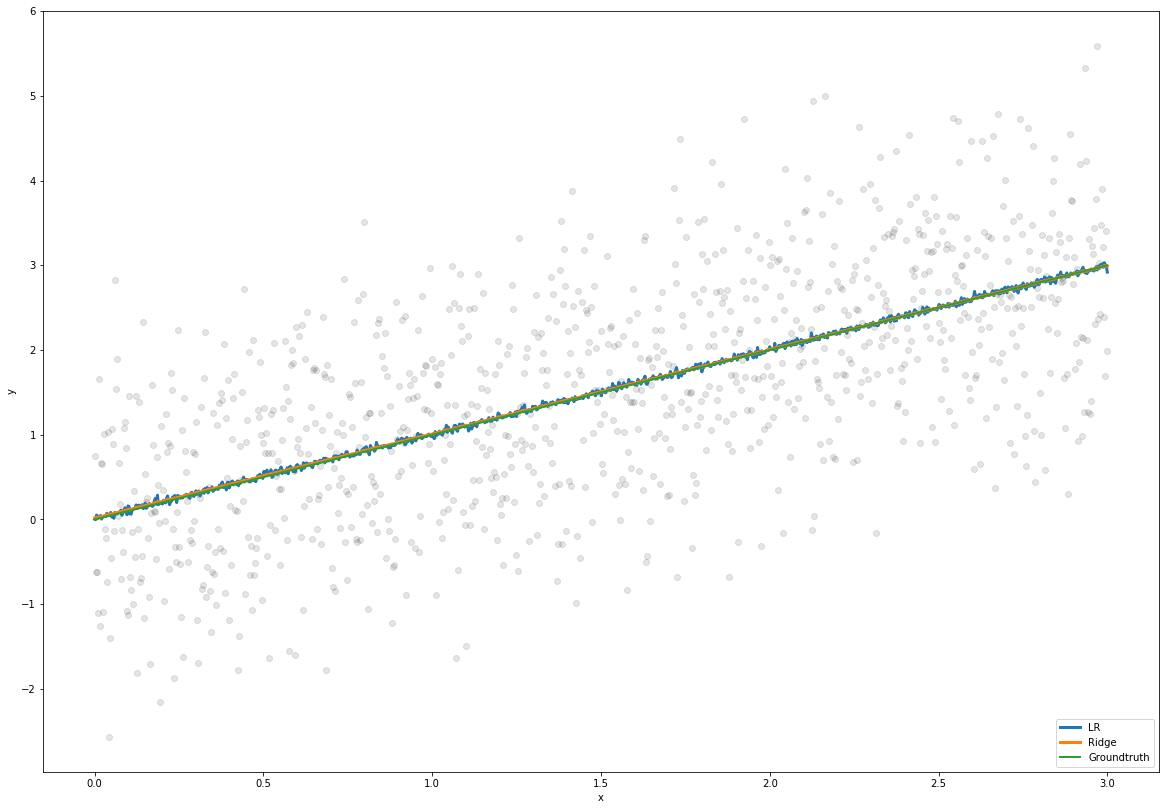

In [1060]:
plt.figure(figsize=(20,14))
plt.scatter(X[:,0], y, c="black", alpha=0.1)
plt.plot(X[:,0], y_pred_LR, linewidth=3)
plt.plot(X[:,0], y_pred_Ridge, linewidth=3)
plt.plot(X[:,0], y_gt, linewidth=2)
plt.legend(["LR", "Ridge", "Groundtruth"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

График для разности предсказанных ответов и истинных:

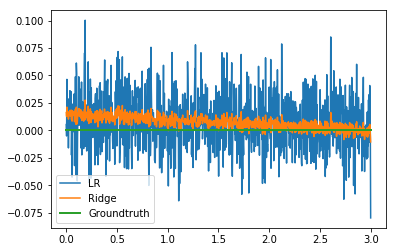

In [1061]:
plt.plot(X[:,0], y_pred_LR - y_gt)
plt.plot(X[:,0], y_pred_Ridge - y_gt)
plt.plot(X[:,0], np.zeros(N), linewidth=2)
plt.legend(["LR", "Ridge", "Groundtruth"], loc=3)
plt.show()

In [1062]:
print(np.sum((y_pred_LR - y_gt)**2))
print(np.sum((y_pred_Ridge - y_gt)**2))

0.6749608339721069
0.08824013810765335


In [1063]:
print(LR.coef_)
print(Ridge.coef_)

[[ 1.48197946 -0.23846318 -0.00345136]]
[[ 1.06269809 -0.02939027 -0.00313187]]


Значение MSE при регрессии Ridge меньше MSE линейной ререссии. Также веса в Ridge меньше, чем в линейной регрессии, так как веса регуляризуются по квадрату вектора. Поэтому предсказанные методом Ridge значения более приближены к настоящим

#### Эксперимент 4

Рассмотрим последний предложенный вам вид регрессии: Lasso. Основным его свойством является возможность отбора признаков, в чём вам и придётся убедится. Сгенеририруйте двумерную выборку для зашумлённой функции $y = x_1 + x_2 + \epsilon$, $x_1$ и $x_2$ образуют равномерную линейную сетку на квадрате [0,1]x[0,1], $\epsilon \sim \mathcal{N}(0, 1)$, и добавьте в неё два линейно зависимых признака с шумом: 

$$x_3 = 2x_1 + \delta, \quad \delta \sim \mathcal{N}(0, 0.01)$$, 
$$x_4 = 0.5x_1 + x_2 + \nu, \quad \nu \sim \mathcal{N}(0, 0.25)$$ 

После этого запустите на данной выборке регрессию Ridge и Lasso, сравните получаемые веса для признаков. Какие эффекты вы наблюдаете? В чём различие? Как именно в Lasso производится явное уменьшение размерности данных?

Пример вызова класса, выполняющего регрессию Lasso:

    Lasso = lm.Lasso()
    Lasso.fit(X_train, y_train)
    y_pred = LR.predict(X_train)

In [522]:
def f_target(X):
    return np.sum(X, axis=1).reshape((X.shape[0], 1))

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

"""Генерация выборки"""
n = 30
D = 2
N = n**D
X, y, y_gt = gen_data(n, D, 0, 3, f_target, f_noise)
delta = np.random.normal(loc=0, scale=0.1, size=N).reshape((N, 1))
nu = np.random.normal(loc=0, scale=0.5, size=N).reshape((N, 1))
x3 = 2*X[:,0].reshape((N, 1)) + delta
x4 = 0.5*X[:,0].reshape((N, 1)) + X[:,1].reshape((N, 1)) + nu
X = np.concatenate([X, x3, x4], axis=1)

Обучите на выборке регрессии Lasso и Ridge на выборке (X, y), используя вызовы соответствующих классов.

In [523]:
from sklearn.linear_model import Ridge, Lasso

Ridge = Ridge()
Ridge.fit(X, y)
y_pred_Ridge = Ridge.predict(X)
err_1 = mean_squared_error(y_pred_Ridge, y_gt)

Lasso = Lasso()
Lasso.fit(X, y)
y_pred_Lasso = Lasso.predict(X)
err_2 = mean_squared_error(y_pred_Lasso, y_gt)

In [524]:
print(Lasso.coef_)
print(Ridge.coef_)

[0.         0.         0.19967686 0.        ]
[[ 1.11355619  0.90510119 -0.05029045  0.02087836]]


Lasso и Ridge позволяют бороться с мультиколлинеарностью. Регрессия Lasso обнуляет веса. Ridge снижает вес, но не обнуляет, что предполагает отсутствие выбора признаков (то есть использует все признаки). Lasso использует использует абсолютные значения в функции штрафа, вместо квадратов. Lasso выбирает признаки, но при их высокой взаимной корреляции эффективность отбора снижается.



## Часть 2. Задача с реальными данными

В данной части вам предлагается, используя изученные методы построения регрессии, проанализировать реальный датасет.

Будем исследовать данные по преступности в разных штатах США. От вас потребуется по большому количеству признаков, связанных с социальными и экономическими показателями, восстановить целевую переменную: среднее число преступлений на 100 тысяч человек. С полным описанием датасета можно ознакомиться здесь: https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime

In [23]:
import pandas as pd

In [24]:
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data",
                   na_values="?", header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


Исходя из описания датасета, первые 5 колонок не являются информативными признаками, убираем их.

In [25]:
data = data.iloc[:,5:]

#### 1. Вычислите и визуализируйте попарную корреляцию пирсона между всеми признаками.  Как коррелирующие признаки будут влиять на обучение линейной регрессии. Какие выводы можно сделать?

Для визуализации можно использовать seaborn.heatmap()

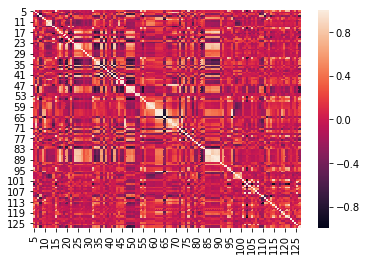

In [26]:
import seaborn
corr = data.corr()
seaborn.heatmap(corr)

Есть признаки, которые сильно коррелируют между собой(корреляция от 0.8), но их немного. Также есть признаки с отрицательной корреляцией. 
На обучение линейной регрессии негативно повлияют сильно коррелирующие признаки, поэтому их нужно исключить или преобразовать.

#### 2. Найдите признаки у которых корреляция с предсказваемым значением максимальна и минимальна. Изобразите на графиках зависимость найденных признаков от предсказываемого значения.

In [27]:
mxcor = np.where(abs(data.corr().iloc[:-1, -1]) == abs(data.corr().iloc[:-1, -1]).max())[0][0]
mncor = np.where(abs(data.corr().iloc[:-1, -1]) == abs(data.corr().iloc[:-1, -1]).min())[0][0]
print('Признак c максимальной корреляцией к предсказваемому значению:',mxcor)
print('Признак c минимальной корреляцией к предсказваемому значению:',mncor)

Признак c максимальной корреляцией к предсказваемому значению: 44
Признак c минимальной корреляцией к предсказваемому значению: 95


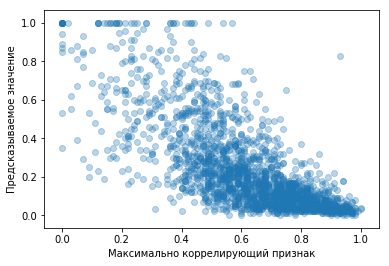

In [29]:
plt.scatter(data.iloc[:, mxcor].dropna(), data.iloc[:,-1].dropna(), alpha=0.3)
plt.xlabel('Максимально коррелирующий признак')
plt.ylabel('Предсказываемое значение')
plt.show()

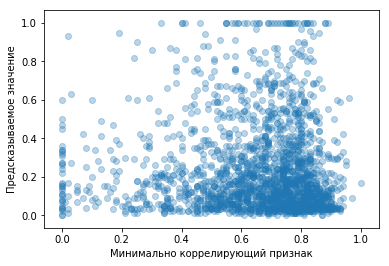

In [1211]:
plt.scatter(data.iloc[:, mncor].dropna(), data.iloc[:,-1].dropna(), alpha=0.3)
plt.xlabel('Минимально коррелирующий признак')
plt.ylabel('Предсказываемое значение')
plt.show()

#### 3. Постройте гистограмму распределения предсказываемого значения.

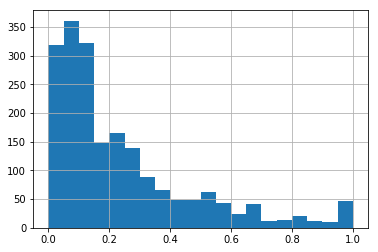

In [835]:
data.iloc[:,-1].hist(bins = 20)

Как видно из заголовка датасета, в нём присутствует много пропущенных значений. Рассмотренные нами алгоритмы регрессии не содержат в себе методов обработки пропущенных значений, поэтому нам нужно избавиться от них на этапе предобработки данных.


#### 4. Замените все пропущенные значения на средние по соответствующим признакам. Сохраните результат в переменную data.

In [836]:
data = data.fillna(data.mean())

In [837]:
data.head()

,5,6,7,8,9,10,11,12,13,14,...,118,119,120,121,122,123,124,125,126,127
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.03


Разделим данные на три выборки: по одной мы будем обучать регрессию, по второй -- гиперпараметры, по третьей -- тестировать качество:

In [838]:
data = data.reindex(np.random.permutation(data.index))
data_train, data_validate, data_test = np.array_split(data, 3)

Учтём, что целевая переменная -- это последний столбец данных:

In [839]:
X_train = data_train.iloc[:,:-1]
y_train = data_train.iloc[:,-1]
X_validate = data_validate.iloc[:,:-1]
y_validate = data_validate.iloc[:,-1]
X_test = data_test.iloc[:,:-1]
y_test = data_test.iloc[:,-1]

In [840]:
X_train_new = np.concatenate([X_train, X_validate], axis=0)
y_train_new = np.concatenate([y_train, y_validate], axis=0)

#### 5. Обучите обычную линейную регрессию на выборке (X_train_new, y_train_new).  Оцените качество предсказания на данных X_test.

Качество оценивайте, как среднеквадратичное отклонения ваших предсказаний на тестовой выборке от истинных значений: $$\text{err}\ (y^{pred}, y^{test}) = \frac{1}{N} \sum_{n=1}^N (y^{pred}_n - y^{test}_n)^2$$

In [898]:
LR = lm.LinearRegression()
LR.fit(X_train_new, y_train_new)
y_pred_LR = LR.predict(X_test)
err = mean_squared_error(y_pred_LR, y_test)
err

0.02056863091889924

#### 6. Используя sklearn.model_selection.GridSearchCV(), подберите оптимальные значения гиперпараметра alpha для  регрессий Ridge и Lasso

In [929]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso

parameters = {'alpha':[1, 5, 10, 15]}
Ridge = Ridge()
clf_ridge = GridSearchCV(Ridge, parameters)
clf_ridge.fit(X_train_new, y_train_new)

GridSearchCV(cv=None, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [1, 5, 10, 15]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [930]:
clf_ridge.best_params_

{'alpha': 5}

In [901]:
parameters = {'alpha':[0.0001, 0.001, 0.01, 0.05, 0.1, 1,10.0]}
Lasso = Lasso()
clf_lasso = GridSearchCV(Lasso, parameters)
clf_lasso.fit(X_train_new, y_train_new)

GridSearchCV(cv=None, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 1, 10.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [902]:
clf_lasso.best_params_

{'alpha': 0.0001}

Рассмотрите значения полученных весов для регрессии в с лучшим alpha для Ridge и Lasso. В чём их существенная разница? Какие выводы вы можете сделать о структуре данных по регрессионным весам?

In [931]:
Ridge = lm.Ridge(alpha=5)
Ridge.fit(X_train_new, y_train_new)

Lasso = lm.Lasso(alpha=0.001)
Lasso.fit(X_train_new, y_train_new)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [932]:
print(Ridge.coef_)

[ 0.0073078   0.00323452  0.13296065 -0.09491368 -0.04208056  0.0382229
 -0.00135714 -0.05619958 -0.01838053  0.02697091  0.00342597  0.05302842
  0.02407528 -0.02714313  0.03919425 -0.07170363  0.00420221  0.02901099
 -0.05356753  0.01201146 -0.01674975 -0.0291004  -0.00527628 -0.02223286
  0.04111152  0.04782299  0.01250927 -0.00179565 -0.05236301 -0.05107637
  0.03893909 -0.01279894 -0.01685807  0.04220694 -0.0306572  -0.00177172
  0.02957799 -0.00206812  0.07027374  0.05591508 -0.01860584  0.00681169
 -0.00157891 -0.0680325  -0.09721955 -0.04421476 -0.02035471  0.00417259
 -0.08064689 -0.02795575  0.15482129 -0.01231893  0.02684613 -0.01671662
  0.00114268  0.01898592 -0.01530433 -0.00156195  0.01401805  0.01757827
  0.00650886 -0.02755591 -0.02076148 -0.01956956  0.04178269 -0.03617661
  0.01089859 -0.04860569  0.04147068  0.02566622 -0.00114059  0.08870954
 -0.06990888 -0.00668796  0.0763674  -0.03617663 -0.00857831  0.01000277
  0.00109799 -0.01822242  0.01811434  0.01678524 -0.

In [906]:
print(Lasso.coef_)

[ 0.         -0.          0.08504366 -0.1003571  -0.          0.01054162
 -0.         -0.         -0.          0.          0.          0.04587853
 -0.         -0.          0.00081055 -0.00923317  0.          0.0101432
 -0.         -0.          0.          0.         -0.         -0.
  0.0147605   0.01170756  0.          0.          0.          0.
  0.         -0.          0.         -0.         -0.         -0.
  0.         -0.          0.115174    0.          0.          0.
 -0.         -0.         -0.25863853 -0.         -0.         -0.
 -0.04741104  0.          0.21550475  0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.          0.          0.          0.          0.         -0.
  0.         -0.          0.0625143   0.         -0.00312758  0.09365222
 -0.05360426 -0.          0.05242277 -0.          0.          0.
  0.          0.          0.          0.         -0.         -0.
  0.          0.          0.00118667  0.         -0.0139152

Исходя из весов регрессии Lasso, отберите наиболее релевантные признаки и обучите две лучшие регрессионные модели только на них. Насколько сильно при этом изменилась средняя ошибка? Что это говорит о структуре данных? 

In [908]:
coefs = Lasso.coef_

In [935]:
params = []
for i in range(coefs.shape[-1]):
    if coefs[i] != 0:
        params.append(i)

In [925]:
X_test_new = np.array(X_test)[:,params]
Ridge = lm.Ridge(alpha=8)
Ridge.fit(X_train_new[:,params], y_train_new)
y_pred_r= Ridge.predict(X_test_new)
err = mean_squared_error(y_pred_r, y_test)
err


0.01914993368070557

In [926]:
X_test_new = np.array(X_test)[:,params]
Lasso = lm.Lasso(alpha=0.001)
Lasso.fit(X_train_new[:,params], y_train_new)
y_pred_l = Lasso.predict(X_test_new)
err = mean_squared_error(y_pred_l, y_test)
err

0.019052778472339195

При выбранном гиперпараметре регрессия Lasso обнулила многие веса, на основе этого можно сделать вывод, что среди данных много маловажных признаков. Также все коэффиценты сравнительно небольшие, из этого следует, что все признаки были масштабированы и отобраны

Значение ошибки снизилось (если сравнивать с ошибкой на линейной регрессии)

#### 7. Обучите KNN на выборке (X_train_new, y_train_new).  Оцените качество предсказания на данных X_test.

In [854]:
KNNs = KNeighborsRegressor(n_neighbors=3)
KNNs.fit(X_train_new,y_train_new)
y_pred_KNNs = KNNs.predict(X_test)
err = mean_squared_error(y_pred_KNNs, y_test)
err

0.023404300535475233

#### 8. Используя sklearn.model_selection.GridSearchCV(), подберите оптимальные значения параметров n_neighbors и p при выборе  metric='minkowski'

In [855]:
from sklearn.model_selection import GridSearchCV

In [865]:
parameters = {'n_neighbors':[ 9, 10, 11, 12, 13], 'p':[1, 2, 3, 4, 5]}
KNNs = KNeighborsRegressor(metric='minkowski')
clf_KNNs = GridSearchCV(KNNs, parameters)
clf_KNNs.fit(X_train_new, y_train_new)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [9, 10, 11, 12, 13], 'p': [1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [866]:
clf_KNNs.best_params_

{'n_neighbors': 13, 'p': 1}

In [867]:
KNNs = KNeighborsRegressor(n_neighbors=13, p=1, metric='minkowski')
KNNs.fit(X_train_new,y_train_new)
y_pred_KNNs = KNNs.predict(X_test)
err = mean_squared_error(y_pred_KNNs, y_test)
err

0.019847726705639127

С помощью какого алгоритма удалось достичь лучшего качества?

Лучшего качества удалось достичь на регрессии Lasso с оптимальным гиперпараметром (MSE ≈ 0.01905). Затем идет регрессия Ridge, также с настраиваемым гиперпараметром (MSE ≈ 0.01914)

Напишите отчёт по исследованному вами датасету. Какими он обладает ключевыми свойствами? Какие методы вам пришлось использовать, чтобы его исследовать? Что вы можете сказать об информативности используемых в нём признаков? Какой из опробованных методов вы бы предпочли использовать на нём и почему?

В датасете все признаки нормированы, то есть можно выделить ключевое свойство как масштабированность. Много пропущенных значений. Немного сильно кореллирующих признаков. 

Использовались такие методы, как обучение линейной регрессии, обучение линейной регрессии с регуляризацией при помощи метода Lasso и метода Ridge, обучение регрессии при помощи метода k-ближайших соседей. Также использовалось разделение на выборки для кросс-валидации и подбор гиперпараметров.

Признаки являются в основном информативными, потому что среднеквадратичное отклонение предсказаний на тестовой выборке от истинных значений небольшое. Когда Lasso обнулило признаки, значение mse ненамного снизилось по сравнению с mse при линейной регрессии. Тем не менее, коллинеарно зависимых признаков немного, лучшее значение качества достигается при помощи метода Lasso, поэтому стоит использовать его.